# Import Data

In [ ]:
import os
import researchpy as rp
import pandas as pd
import pickle

import statsmodels.api as sm
from statsmodels.formula.api import ols

dir = os.scandir('data/')
experiments = list(filter(lambda x: x.name.endswith(".pickle"), dir))

df = pd.DataFrame()

for experiment in experiments:
    dffile = open(experiment.path, 'rb')      
    read_df = pickle.load(dffile)
    read_df = read_df[['max_epochs', 'executor_memory', 'executor_cores', 'model', 'accuracy', 'time']]
    df = pd.concat([df, read_df])

        
acc_df = pd.DataFrame({'y': df["accuracy"],
                       'epochs': df["max_epochs"],
                       'memory': df["executor_memory"],
                       'cores': df["executor_cores"],
                       'model': df["model"]})

time_df = pd.DataFrame({'y': df["time"],
                        'epochs': df["max_epochs"],
                        'memory': df["executor_memory"],
                        'cores': df["executor_cores"],
                        'model': df["model"]})

print(f"Imported {len(experiments)} experiments!")

## DataFrame Summaries

In [ ]:
summary_acc_df = rp.summary_cont(acc_df.groupby(['model', 'epochs', 'cores', 'memory']))['y']
summary_acc_df

In [ ]:
summary_time_df = rp.summary_cont(time_df.groupby(['model', 'epochs', 'cores', 'memory']))['y']
summary_time_df

## ANOVA analysis

In [ ]:
def anova_analysis(input_df):
    model = ols('y ~ C(model)*epochs*cores*memory', input_df).fit()
    
    res = sm.stats.anova_lm(model, typ=2)
    res['PR(>F) < 0.05'] = res['PR(>F)'] < 0.05
    return res, model

In [ ]:
acc_res, acc_model = anova_analysis(acc_df)
print("Accuracy ANOVA Analysis")
acc_res

In [ ]:
time_res, time_model = anova_analysis(time_df)
print("Time ANOVA Analysis")
time_res

In [ ]:
epoch_model_acc = ols('epochs ~ C(model)*cores*memory*y', acc_df).fit()
epoch_model_time = ols('epochs ~ C(model)*cores*memory*y', time_df).fit()

def epoch_model_predict(trained_model, model, cores, memory, y):
    assert model.lower() in ['bi-rnn', 'lenet5'], 'unsupported model (supported: bi-rnn or lenet5)'
    assert cores > 0, 'impossible to run on 0 cores'
    assert memory > 0, 'impossible to run without memory'
    assert y > 0, 'either time or accuracy should be >0 (time or accuracy depends on the trained model)'
    return trained_model.predict(exog={'model': model.lower(), 'cores': cores, 'memory': memory, 'y': y})[0]

In [ ]:
prediction_with_acc = epoch_model_predict(epoch_model_acc, model='Bi-rnn', cores=10, memory=64, y=0.6)
prediction_with_time = epoch_model_predict(epoch_model_time, model='Bi-rnn', cores=10, memory=64, y=300)

print(f'Predicted epochs with accuracy: {prediction_with_acc}')
print(f'Predicted epochs with time: {prediction_with_time}')

## Check assumptions

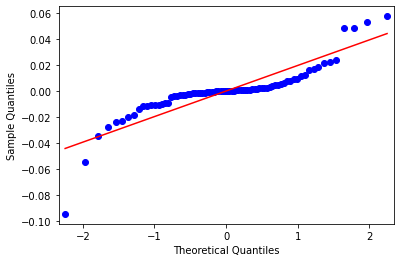

In [76]:
from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np

errors = []
for i in range(16):
    mean = acc_df['y'][i].mean()
    for x in acc_df['y'][i]:
        errors.append(x - mean)
    
qqplot(np.array(errors), line='s')
pyplot.show()


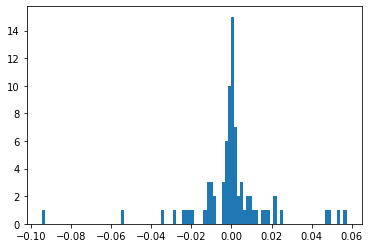

In [78]:
res = plt.hist(np.array(errors), bins=100)